# DCGAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Parameters
lr = 0.0002
beta1 = 0.5
num_epochs = 50
batch_size = 64
noise_dim = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)


Files already downloaded and verified


In [4]:
# DCGAN Generator
class DCGANGenerator(nn.Module):
    def __init__(self, noise_dim=100):
        super(DCGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 4 * 4 * 512),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# DCGAN Discriminator
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(4 * 4 * 512, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


In [5]:
generator = DCGANGenerator(noise_dim).to(device)
discriminator = DCGANDiscriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()


In [70]:
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        optimizer_D.zero_grad()

        # Loss for real images
        real_output = discriminator(real_imgs)
        d_loss_real = criterion(real_output, real_labels)

        # Loss for fake images
        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = generator(z)
        fake_output = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        # Total Discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        fake_output = discriminator(fake_imgs)
        g_loss = criterion(fake_output, real_labels)

        g_loss.backward()
        optimizer_G.step()

        # Print progress
        # if i % 100 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], "
        #           f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch [1/50], Step [390/391], D Loss: 0.5490, G Loss: 3.4417
Epoch [2/50], Step [390/391], D Loss: 0.1291, G Loss: 4.8881
Epoch [3/50], Step [390/391], D Loss: 0.7180, G Loss: 1.3166
Epoch [4/50], Step [390/391], D Loss: 0.3107, G Loss: 7.0768
Epoch [5/50], Step [390/391], D Loss: 0.0140, G Loss: 5.4746
Epoch [6/50], Step [390/391], D Loss: 2.1190, G Loss: 3.9766
Epoch [7/50], Step [390/391], D Loss: 0.0014, G Loss: 12.4088
Epoch [8/50], Step [390/391], D Loss: 0.0443, G Loss: 4.1127
Epoch [9/50], Step [390/391], D Loss: 0.5385, G Loss: 6.8247
Epoch [10/50], Step [390/391], D Loss: 0.0255, G Loss: 4.8250
Epoch [11/50], Step [390/391], D Loss: 0.0069, G Loss: 7.9811
Epoch [12/50], Step [390/391], D Loss: 0.3899, G Loss: 3.5796
Epoch [13/50], Step [390/391], D Loss: 0.0180, G Loss: 11.1524
Epoch [14/50], Step [390/391], D Loss: 0.0251, G Loss: 5.3048
Epoch [15/50], Step [390/391], D Loss: 0.1174, G Loss: 4.3899
Epoch [16/50], Step [390/391], D Loss: 0.0008, G Loss: 10.9872
Epoch [17/50],

### To plot losses

Epoch [1/50], D Loss: 0.4833, G Loss: 6.1448
Epoch [2/50], D Loss: 0.4425, G Loss: 5.2311
Epoch [3/50], D Loss: 0.5379, G Loss: 4.7275
Epoch [4/50], D Loss: 0.6060, G Loss: 4.2499
Epoch [5/50], D Loss: 0.5320, G Loss: 4.4390
Epoch [6/50], D Loss: 0.2832, G Loss: 5.1193
Epoch [7/50], D Loss: 0.3669, G Loss: 6.6505
Epoch [8/50], D Loss: 0.3151, G Loss: 4.8504
Epoch [9/50], D Loss: 0.1118, G Loss: 9.0552
Epoch [10/50], D Loss: 0.4162, G Loss: 5.0797
Epoch [11/50], D Loss: 0.3731, G Loss: 4.9803
Epoch [12/50], D Loss: 0.3393, G Loss: 5.4113
Epoch [13/50], D Loss: 0.2122, G Loss: 7.2740
Epoch [14/50], D Loss: 0.3010, G Loss: 5.9054
Epoch [15/50], D Loss: 0.3486, G Loss: 5.4142
Epoch [16/50], D Loss: 0.2787, G Loss: 5.8513
Epoch [17/50], D Loss: 0.3276, G Loss: 6.1307
Epoch [18/50], D Loss: 0.1957, G Loss: 6.9438
Epoch [19/50], D Loss: 0.2520, G Loss: 5.9330
Epoch [20/50], D Loss: 0.0763, G Loss: 7.9745
Epoch [21/50], D Loss: 0.3874, G Loss: 5.9571
Epoch [22/50], D Loss: 0.3252, G Loss: 5.93

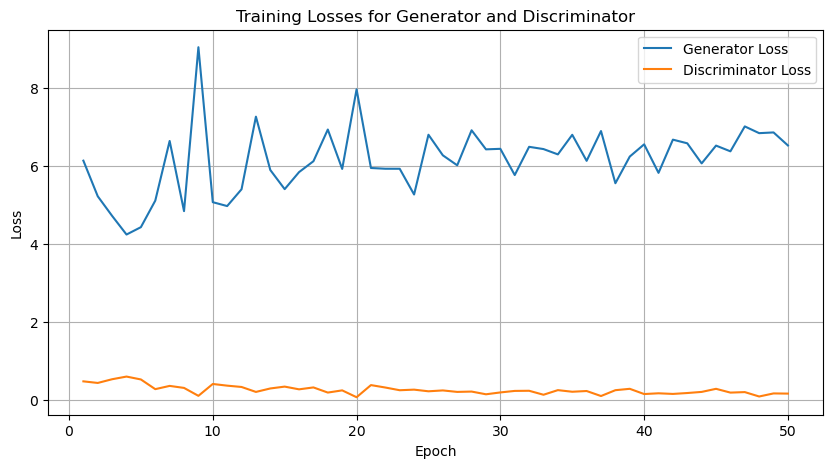

In [6]:
import matplotlib.pyplot as plt

g_losses = []
d_losses = []

# Training loop
for epoch in range(num_epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0 
    for i, (real_imgs, _) in enumerate(dataloader):

        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        
        # generates real and fake labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        optimizer_D.zero_grad()

        real_output = discriminator(real_imgs)
        d_loss_real = criterion(real_output, real_labels)

        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = generator(z)
        fake_output = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        # Total Discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # generator loss (wants discriminator to classify fakes as real)
        fake_output = discriminator(fake_imgs)
        g_loss = criterion(fake_output, real_labels)

        g_loss.backward()
        optimizer_G.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    # avg losses
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_d_loss = epoch_d_loss / len(dataloader)

    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), g_losses, label="Generator Loss")
plt.plot(range(1, num_epochs + 1), d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses for Generator and Discriminator")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import torchvision.utils as vutils

z = torch.randn(10, noise_dim, device=device)
generated_images = generator(z).detach().cpu()
vutils.save_image(generated_images, 'generated_images.png', normalize=True)

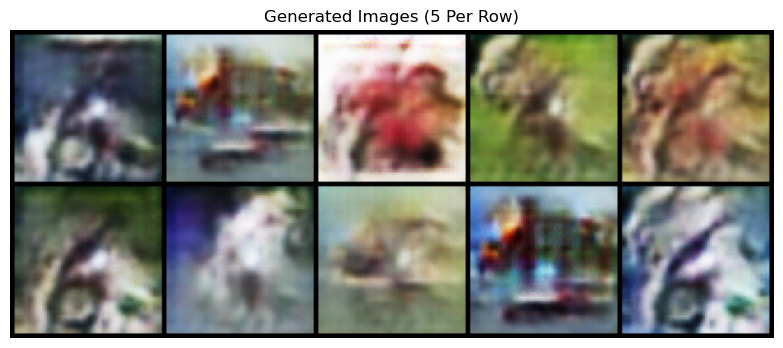

In [8]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

z = torch.randn(10, noise_dim, device=device)
generated_images = generator(z).detach().cpu()

grid = vutils.make_grid(generated_images, nrow=5, normalize=True)

vutils.save_image(grid, 'generated_images.png', normalize=True)

plt.figure(figsize=(10, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Generated Images (5 Per Row)")
plt.show()
